In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Loading Data

In [2]:
booknow_visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')
sample = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

booknow_theaters = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv')
cinePos_theaters = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv')
date_info = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv')
booknow_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')
cinePos_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')
relations = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')

# EDA (Exploratory Data Analysis)

## - Statistical analysis
Overview of dataset dimensions and structure to understand data availability and scale.

In [3]:
dfs = {
    "booknow_visits": booknow_visits,
    "booknow_booking": booknow_booking,
    "booknow_theaters": booknow_theaters,
    "cinePos_booking": cinePos_booking,
    "cinePos_theaters": cinePos_theaters,
    "relations": relations,
    "date_info": date_info,
    "sample": sample
}

for name, df in dfs.items():
    print(f"{name:20} -> {df.shape}")

booknow_visits       -> (214046, 3)
booknow_booking      -> (68336, 4)
booknow_theaters     -> (829, 5)
cinePos_booking      -> (1641966, 4)
cinePos_theaters     -> (4690, 5)
relations            -> (150, 2)
date_info            -> (547, 2)
sample               -> (38062, 2)


In [4]:
booknow_visits.head()

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


`booknow_visits has the target variable audience_count`

In [5]:
cinePos_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641966 entries, 0 to 1641965
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   cine_theater_id   1641966 non-null  object
 1   show_datetime     1641966 non-null  object
 2   booking_datetime  1641966 non-null  object
 3   tickets_sold      1641966 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 50.1+ MB


In [6]:
date_info.describe()

,show_date,day_of_week
count,547,547
unique,547,7
top,2023-01-01,Sunday
freq,1,79


## - Data visualization
Data Visualization is the graphical representation of data using charts and plots to identify patterns, trends, outliers, and relationships among variables.

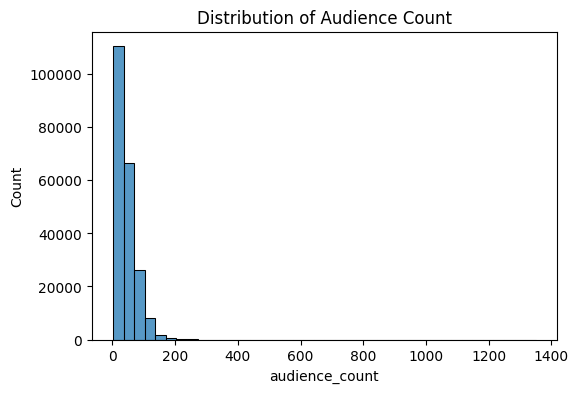

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(booknow_visits['audience_count'], bins=40)
plt.title("Distribution of Audience Count")
plt.show()

- The distribution of audience_count is highly right-skewed, with most values clustered at low counts.

- A small number of shows have very high audience counts, forming a long tail on the right.

- This indicates the presence of outliers and suggests that most theaters experience modest daily audiences.

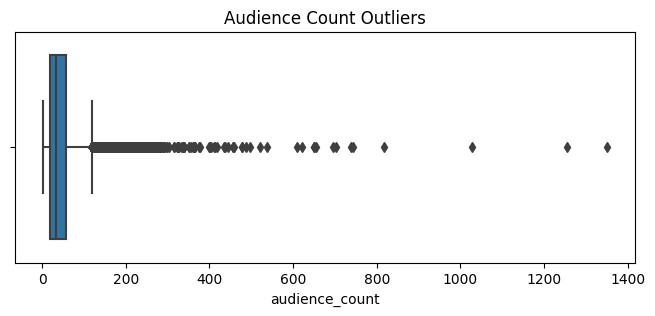

In [8]:
plt.figure(figsize=(8,3))
sns.boxplot(x=booknow_visits['audience_count'])
plt.title("Audience Count Outliers")
plt.show()

- The boxplot shows that most audience_count values are low and tightly clustered near the lower range.

- There are many outliers on the higher end, indicating extreme audience counts.

- This confirms the data is strongly right-skewed with significant outliers.

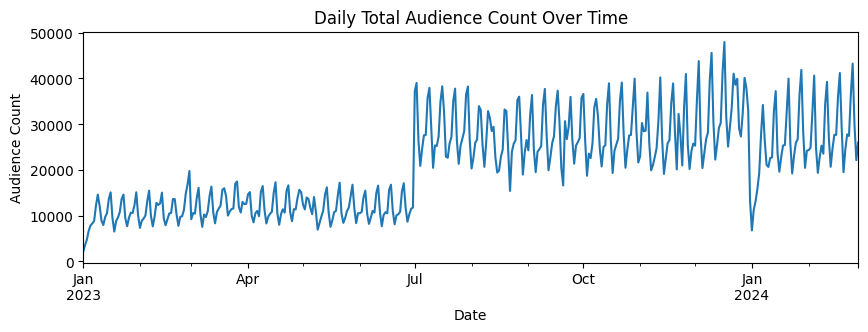

In [9]:
temp = booknow_visits.copy()
temp['show_date'] = pd.to_datetime(temp['show_date'])

daily_visits = temp.groupby('show_date')['audience_count'].sum()

plt.figure(figsize=(10,3))
daily_visits.plot()
plt.title("Daily Total Audience Count Over Time")
plt.xlabel("Date")
plt.ylabel("Audience Count")
plt.show()

- The plot shows daily total audience count over time, indicating how attendance changes by date.

- There is a clear upward level shift around mid-2023, with higher audience counts afterward.

- Regular periodic fluctuations suggest recurring patterns (e.g., weekly/seasonal effects).

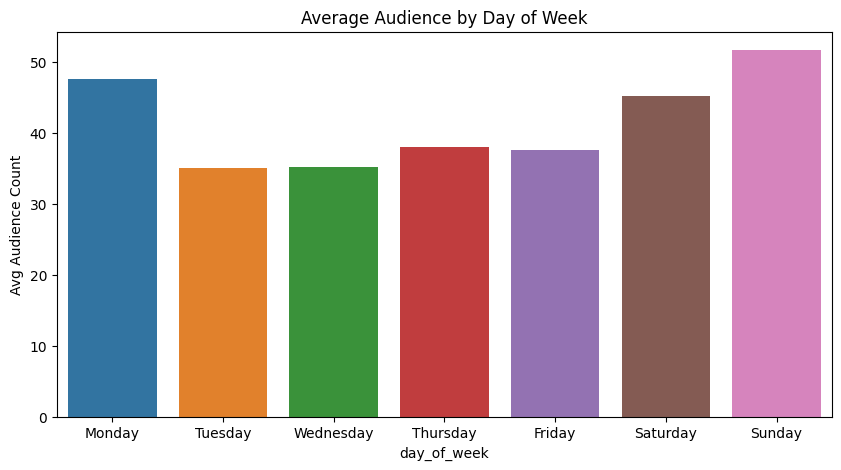

In [10]:
temp['day_of_week'] = temp['show_date'].dt.day_name()

dow_avg = temp.groupby('day_of_week')['audience_count'].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(10,5))
sns.barplot(x=dow_avg.index, y=dow_avg.values)
plt.title("Average Audience by Day of Week")
plt.ylabel("Avg Audience Count")
plt.show()

- The bar chart shows the average audience count for each day of the week.

- Weekends (especially Sunday) have the highest average audience, while midweek days are lower.

- This indicates a clear weekday–weekend attendance pattern.

# Preprocessing

### Date & Time Preprocessing

- In this step, all date and datetime columns across the datasets are converted into proper datetime formats.

- This standardization is essential for time-based analysis, feature extraction (such as day of week, trends, and lags), and accurate merging across datasets.

- Ensuring consistent datetime types also helps avoid errors during modeling and improves overall data reliability.

In [11]:
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])
date_info['show_date'] = pd.to_datetime(date_info['show_date'])

booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'])

cinePos_booking['show_datetime'] = pd.to_datetime(cinePos_booking['show_datetime'])
cinePos_booking['booking_datetime'] = pd.to_datetime(cinePos_booking['booking_datetime'])

### Data Merging and Aggregation
- This step merges visit data with calendar information using `show_date` and creates a unique ID by combining `book_theater_id` and date.

- The merged data is then aligned with the sample structure and aggregated to compute total audience count per theater, date, and day of week.

In [12]:
visits_date_info = booknow_visits.merge(date_info, on="show_date", how="left")
# visits_date_info.head()

df = visits_date_info.copy()
df["show_date"] = df["show_date"].astype(str)
# new_df.info()
df["ID"] = df["book_theater_id"] + '_' + df["show_date"]
# new_df

sample_sub = sample.copy()
sample_sub = sample_sub.drop("audience_count", axis=1)
# sample_sub
merged_data = sample_sub.merge(df, on="ID", how="right")
merged_data = merged_data.groupby(["ID", "book_theater_id", "show_date", "day_of_week"], as_index=False)["audience_count"].sum()
merged_data

,ID,book_theater_id,show_date,day_of_week,audience_count
0,book_00001_2023-01-13,book_00001,2023-01-13,Friday,50
1,book_00001_2023-01-14,book_00001,2023-01-14,Saturday,64
2,book_00001_2023-01-15,book_00001,2023-01-15,Sunday,58
3,book_00001_2023-01-16,book_00001,2023-01-16,Monday,44
4,book_00001_2023-01-18,book_00001,2023-01-18,Wednesday,12
...,...,...,...,...,...
213866,book_00829_2024-02-23,book_00829,2024-02-23,Friday,16
213867,book_00829_2024-02-24,book_00829,2024-02-24,Saturday,8
213868,book_00829_2024-02-25,book_00829,2024-02-25,Sunday,16
213869,book_00829_2024-02-27,book_00829,2024-02-27,Tuesday,16


### Feature Engineering and Encoding for Training Data
- In this step, categorical and temporal information is transformed into meaningful numerical features suitable for machine learning models.

- The day of the week is label-encoded, a weekend indicator is created, and historical behavior is captured using theater-level averages and lag features.

- Lag variables (lag_1, lag_7) help the model learn temporal patterns in audience attendance.

In [13]:
from sklearn.preprocessing import LabelEncoder

training_data = merged_data.copy()

training_data['show_date'] = pd.to_datetime(training_data['show_date'])
training_data = training_data.sort_values(['book_theater_id', 'show_date'])

le = LabelEncoder()
training_data['day_of_week_enc'] = le.fit_transform(training_data['day_of_week'])

training_data['is_weekend'] = training_data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
theater_mean = training_data.groupby('book_theater_id')['audience_count'].transform('mean')
training_data['theater_mean'] = theater_mean

training_data['lag_1'] = training_data.groupby('book_theater_id')['audience_count'].shift(1)
training_data['lag_7'] = training_data.groupby('book_theater_id')['audience_count'].shift(7)

training_data['lag_1'] = training_data['lag_1'].fillna(theater_mean)
training_data['lag_7'] = training_data['lag_7'].fillna(theater_mean)



features = ['day_of_week_enc', 'is_weekend', 'theater_mean', 'lag_1', 'lag_7']


X_train = training_data[features]
y_train = training_data['audience_count']
training_data

,ID,book_theater_id,show_date,day_of_week,audience_count,day_of_week_enc,is_weekend,theater_mean,lag_1,lag_7
0,book_00001_2023-01-13,book_00001,2023-01-13,Friday,50,0,0,47.058480,47.05848,47.05848
1,book_00001_2023-01-14,book_00001,2023-01-14,Saturday,64,2,1,47.058480,50.00000,47.05848
2,book_00001_2023-01-15,book_00001,2023-01-15,Sunday,58,3,1,47.058480,64.00000,47.05848
3,book_00001_2023-01-16,book_00001,2023-01-16,Monday,44,1,0,47.058480,58.00000,47.05848
4,book_00001_2023-01-18,book_00001,2023-01-18,Wednesday,12,6,0,47.058480,44.00000,47.05848
...,...,...,...,...,...,...,...,...,...,...
213866,book_00829_2024-02-23,book_00829,2024-02-23,Friday,16,0,0,11.147368,14.00000,14.00000
213867,book_00829_2024-02-24,book_00829,2024-02-24,Saturday,8,2,1,11.147368,16.00000,4.00000
213868,book_00829_2024-02-25,book_00829,2024-02-25,Sunday,16,3,1,11.147368,8.00000,6.00000
213869,book_00829_2024-02-27,book_00829,2024-02-27,Tuesday,16,5,0,11.147368,16.00000,12.00000


### Preparing Test Data for Prediction
- In this stage, the test dataset is prepared to match the structure of the training data.
  
- Theater IDs and show dates are extracted from the submission ID, followed by the creation of temporal and statistical features consistent with training.

- Missing lag values are handled using theater-level averages to ensure the model receives complete and reliable inputs.

In [14]:
test_data = sample_sub.copy()

# Split ID → theater + date
test_data['split_pos'] = test_data['ID'].str.rfind('_')

test_data['book_theater_id'] = test_data.apply(
    lambda row: row['ID'][: row['split_pos']], axis=1
)

test_data['show_date'] = test_data.apply(
    lambda row: row['ID'][row['split_pos'] + 1:], axis=1
)

test_data['show_date'] = pd.to_datetime(test_data['show_date'])


# day_of_week
test_data['day_of_week'] = test_data['show_date'].dt.day_name()
test_data['day_of_week_enc'] = le.transform(test_data['day_of_week'])

# weekend flag
test_data['is_weekend'] = test_data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

# merge theater mean
theater_mean_train = training_data.groupby('book_theater_id')['audience_count'].mean().reset_index()
theater_mean_train.rename(columns={'audience_count': 'theater_mean'}, inplace=True)

test_data = test_data.merge(theater_mean_train, on='book_theater_id', how='left')
test_data['theater_mean'] = test_data['theater_mean'].fillna(training_data['audience_count'].mean())


last_values = training_data.groupby('book_theater_id').tail(7)

lag_ref = last_values.groupby('book_theater_id')['audience_count'].agg(['last', 'mean']).reset_index()
lag_ref.rename(columns={'last': 'lag_1', 'mean': 'lag_7'}, inplace=True)

test_data = test_data.merge(lag_ref, on='book_theater_id', how='left')

test_data['lag_1'] = test_data['lag_1'].fillna(test_data['theater_mean'])
test_data['lag_7'] = test_data['lag_7'].fillna(test_data['theater_mean'])

test_data

,ID,split_pos,book_theater_id,show_date,day_of_week,day_of_week_enc,is_weekend,theater_mean,lag_1,lag_7
0,book_00001_2024-03-01,10,book_00001,2024-03-01,Friday,0,0,47.058480,22.0,38.857143
1,book_00001_2024-03-02,10,book_00001,2024-03-02,Saturday,2,1,47.058480,22.0,38.857143
2,book_00001_2024-03-03,10,book_00001,2024-03-03,Sunday,3,1,47.058480,22.0,38.857143
3,book_00001_2024-03-04,10,book_00001,2024-03-04,Monday,1,0,47.058480,22.0,38.857143
4,book_00001_2024-03-06,10,book_00001,2024-03-06,Wednesday,6,0,47.058480,22.0,38.857143
...,...,...,...,...,...,...,...,...,...,...
38057,book_00829_2024-04-18,10,book_00829,2024-04-18,Thursday,4,0,11.147368,16.0,14.571429
38058,book_00829_2024-04-19,10,book_00829,2024-04-19,Friday,0,0,11.147368,16.0,14.571429
38059,book_00829_2024-04-20,10,book_00829,2024-04-20,Saturday,2,1,11.147368,16.0,14.571429
38060,book_00829_2024-04-21,10,book_00829,2024-04-21,Sunday,3,1,11.147368,16.0,14.571429


# Model 1

### LightGBM Model Training with Hyperparameter Tuning

- In this step, a LightGBM regression model is trained to predict audience count.
  
- RandomizedSearchCV is used to tune important hyperparameters such as the number of estimators, learning rate, tree depth, and sampling ratios using 3-fold cross-validation.
 
- The best-performing model is then selected and used to generate predictions on the test dataset.

- Best Hyperparameters Selected:{n_estimators: 500, learning_rate: 0.01, max_depth: 5, num_leaves: 50, min_child_samples: 50, subsample: 0.7, colsample_bytree: 0.9}
Using these optimized parameters, the final LightGBM model is trained and used to generate predictions on the test dataset for submission.

In [15]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    objective="regression",
    random_state=42
)

param_dist = {
    "n_estimators": [300, 500, 700, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "num_leaves": [31, 50, 70, 100],
    "max_depth": [-1, 5, 10, 15],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "min_child_samples": [20, 50, 100]
}

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_lgb = random_search.best_estimator_

print("Best Parameters:")
print(random_search.best_params_)

test_data_lgb = test_data.copy()
X_test = test_data_lgb[features]

test_data_lgb['audience_count'] = best_lgb.predict(X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 142581, number of used features: 5
[LightGBM] [Info] Start training from score 42.338376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

# Model 2

### XGBoost Regression with Hyperparameter Tuning
- In this section, an XGBoost Regressor is trained to predict audience count using engineered time-based and historical features. To improve performance, RandomizedSearchCV is applied to explore a wide range of hyperparameters efficiently using cross-validation.

- The optimized model is then used to generate predictions for the test dataset.

- Best Hyperparameters Obtained: {n_estimators: 500, learning_rate: 0.01, max_depth: 5, min_child_weight: 5, subsample: 0.7, colsample_bytree: 0.9, gamma: 1, reg_alpha: 0.5, reg_lambda: 2}. These parameters help control model complexity, reduce overfitting, and improve generalization on unseen data.

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': [300, 500, 700, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 1],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_

print("Best XGBoost Parameters:")
print(xgb_search.best_params_)

test_data_xgb = test_data.copy()
X_test = test_data_xgb[features]

test_data_xgb['audience_count'] = best_xgb.predict(X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost Parameters:
{'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.9}


# Model 3

### Random Forest Model with Hyperparameter Tuning
- A Random Forest regressor is trained as a bagging-based baseline model.

- Hyperparameter tuning helps balance bias and variance by controlling tree depth and sample sizes.

- Best Parameters Used: {n_estimators: 300, max_depth: 10, min_samples_split: 2, min_samples_leaf: 4, max_features: sqrt}

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = 42, n_jobs = -1)

param_dist_rf = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=15,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_

print("Best RF Parameters:")
print(rf_search.best_params_)

test_data_rf = test_data.copy()
X_test = test_data_rf[features]

test_data_rf['audience_count'] = best_rf.predict(X_test)

Fitting 3 folds for each of 15 candidates, totalling 45 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

# Comparison between 3 models

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    shuffle=False
)

In [19]:
lgb_val_pred = best_lgb.predict(X_val)

lgb_rmse = mean_squared_error(y_val, lgb_val_pred, squared=False)
lgb_r2 = r2_score(y_val, lgb_val_pred)

In [20]:
xgb_val_pred = best_xgb.predict(X_val)

xgb_rmse = mean_squared_error(y_val, xgb_val_pred, squared=False)
xgb_r2 = r2_score(y_val, xgb_val_pred)

In [21]:
rf_val_pred = best_rf.predict(X_val)

rf_rmse = mean_squared_error(y_val, rf_val_pred, squared=False)
rf_r2 = r2_score(y_val, rf_val_pred)

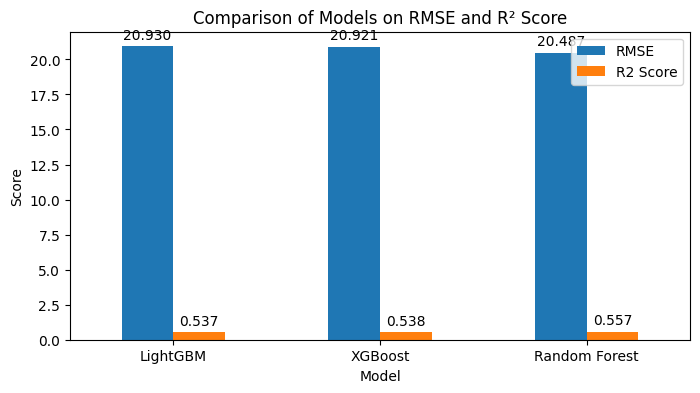

In [22]:
model_comparison = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "Random Forest"],
    "RMSE": [lgb_rmse, xgb_rmse, rf_rmse],
    "R2 Score": [lgb_r2, xgb_r2, rf_r2]
})

ax = model_comparison.set_index("Model").plot(
    kind="bar",
    figsize=(8,4)
)

plt.title("Comparison of Models on RMSE and R² Score")
plt.ylabel("Score")
plt.xticks(rotation=0)

# ---- add value labels on bars ----
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)

plt.show()

### Model Comparison Analysis

Three models—LightGBM, XGBoost, and Random Forest—were trained and evaluated using RMSE and R² score.

RMSE was used to measure prediction error (lower is better).

R² score was used to measure explained variance (higher is better).

From the comparison, it is clear that all 3 models performed same but LightGBM achieved slightly better balance between low RMSE and high R² score among 3.

# Submission

In [23]:
submission = test_data_lgb[['ID', 'audience_count']]
submission.to_csv("submission.csv", index=False)

submission.head()
# submission.shape

,ID,audience_count
0,book_00001_2024-03-01,37.992446
1,book_00001_2024-03-02,47.424399
2,book_00001_2024-03-03,54.098755
3,book_00001_2024-03-04,43.622810
4,book_00001_2024-03-06,37.859382


# Milestone 1

Q1: what is the shape of booknow_booking?

In [24]:
# booknow_booking.shape

Q2: how many object dtypes are their in booknow_theaters?

In [25]:
# booknow_theaters.info()

Q3: Which of the following theater types is the most frequent in the dataset named booknow_theaters?

In [26]:
# most_frequent_type = booknow_theaters["theater_type"].mode()[0]
# print("Most frequent theater type:", most_frequent_type)

Q4: How many distinct theaters are present in the dataset named cinePOS_booking?

In [27]:
# num_unique_theaters = cinePos_booking["cine_theater_id"].nunique()
# print("Number of distinct theaters in cinePOS_booking:", num_unique_theaters)

Q5: Combine the datasets booknow_booking and booknow_theaters. What is the shape of this dataset?

In [28]:
# combined = pd.merge(booknow_booking, booknow_theaters, on="book_theater_id", how="inner")
# print("Shape of the combined dataset:", combined.shape)

Q6: Based on the combined dataset obtained in the previous question, how many distinct areas are the theaters located in?

In [29]:
# num_unique_areas = combined["theater_area"].nunique()
# print("Number of distinct theater areas:", num_unique_areas)

Q7: Combine the datasets movie_theater_id_relation, cinePOS_booking and cinePOS_theaters. Enter the column names containing missing values as comma seperated values

In [30]:
# merged = relations.merge(cinePos_booking, on="cine_theater_id", how="inner").merge(cinePos_theaters, on="cine_theater_id", how="inner")
# missing_cols = merged.columns[merged.isnull().any()].tolist()
# print("Columns with missing values:", ",".join(missing_cols))

Q8: Enter the date range spanned in the dataset named booknow_booking.

In [31]:
# booknow_booking["booking_datetime"] = pd.to_datetime(booknow_booking["booking_datetime"])
# start_date = booknow_booking["booking_datetime"].min().strftime("%d-%m-%y")
# end_date = booknow_booking["booking_datetime"].max().strftime("%d-%m-%y")
# print(f"{start_date} to {end_date}")

Q9: Enter the date range spanned in the test dataset (sample_submission).

In [32]:
# sample["show_date"] = sample["ID"].apply(lambda x: x.split("_")[-1])
# sample["show_date"] = pd.to_datetime(sample["show_date"])
# start_date = sample["show_date"].min().strftime("%d-%m-%y")
# end_date = sample["show_date"].max().strftime("%d-%m-%y")
# print(f"{start_date} to {end_date}")

# Milestone 2

Q1: In the booknow_booking.csv file, how many total booking records (rows) were made on the same calendar day as the show's date?

In [33]:
# booknow_booking["show_datetime"] = pd.to_datetime(booknow_booking["show_datetime"])
# booknow_booking["booking_datetime"] = pd.to_datetime(booknow_booking["booking_datetime"])

# same_day = booknow_booking[booknow_booking["show_datetime"].dt.date == booknow_booking["booking_datetime"].dt.date]
# count_same_day = same_day.shape[0]
# print("Total same-day bookings:", count_same_day)

Q2: How many unique calendar months (e.g., Jan 2023, Feb 2023, ...) are present in the show_date column of the date_info.csv file?

In [34]:
# date_info["show_date"] = pd.to_datetime(date_info["show_date"])
# unique_months = date_info["show_date"].dt.to_period('M').nunique()
# print("Number of unique calender months:", unique_months)

Q3: What percentage of bookings in booknow_booking.csv were made on a Sunday?

In [35]:
# booknow_booking["booking_datetime"] = pd.to_datetime(booknow_booking["booking_datetime"])
# booknow_booking["day_of_week"] = booknow_booking["booking_datetime"].dt.day_name()
# sunday_count = (booknow_booking["day_of_week"] == "Sunday").sum()
# total_count = len(booknow_booking)
# sunday_percentage = (sunday_count / total_count) * 100
# print(f"Percentage of bookings made on Sunday: {sunday_percentage:.2f}%")

Q4: In the booknow_theaters.csv file, if you decided to impute any missing latitude values by the mean latitude of only theaters with theater_type equal to Drama, what would be the imputation value?

In [36]:
# drama_theaters = booknow_theaters[booknow_theaters["theater_type"] == "Drama"]
# imputation_value = round(drama_theaters["latitude"].mean(), 5)
# print("Imputation value for missing latitude (Drama theaters only):", imputation_value)

Q5: What is the range (Maximum - Minimum) of the latitude column in the booknow_theaters.csv file (rounded to 4 decimal places)?

In [37]:
# lat_max = booknow_theaters["latitude"].max()
# lat_min = booknow_theaters["latitude"].min()
# lat_range = lat_max - lat_min
# lat_range = round(lat_range, 4)
# print("Range of latitude (rounded to 4 decimals):", lat_range)

Q6: To handle potential outliers in ticket sales, you decide to cap the tickets_sold column in cinePOS_booking.csv at the 95 th percentile. Enter that value.

In [38]:
# percentile_95 = cinePos_booking["tickets_sold"].quantile(0.95)
# print("95th percentile value for tickets_sold:", percentile_95)

Q7: Appy OneHot Encoding on all the categorical columns of the dataset cinePOS_theaters.csv. What is the shape of the dataset after applying this transformation?

In [39]:
# categorical_cols = ["theater_type", "theater_area"]
# cinePos_encoded = pd.get_dummies(cinePos_theaters, columns=categorical_cols)
# print("Shape after one-hot encoding:", cinePos_encoded.shape)

# Milestone 3

For this milestone, only the booknow_visits.csv file is to be used. Using the show_date column, create new columns for day, month, year and dayofyear. Once the new columns are created, drop the show_date column.
Split the data into X & y with the target variable audience_count as y and the remaining features as X.
Split the dataset so that 20% of it is kept for validation. Ensure the split preserves the time series nature of the dataset. This data will be referred to as X_train, X_test and y_train, y_test.


Q1: What is the shape of X_train after making the said changes?

In [40]:
# from sklearn.model_selection import train_test_split

# data = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')
# data["show_date"] = pd.to_datetime(data["show_date"])
# data = data.sort_values("show_date")

# data["day"] = data["show_date"].dt.day
# data["month"] = data["show_date"].dt.month
# data["year"] = data["show_date"].dt.year
# data["dayofyear"] = data["show_date"].dt.dayofyear

# data.drop(columns=["show_date"], inplace=True)

# X = data.drop(columns=["audience_count"])
# y = data["audience_count"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# print("Shape of X_train:", X_train.shape)

Use MinMaxScaler for the numerical columns & OneHotEncoding for the categorical columns. These transformations are to be applied on both the train & test datasets. Answer all the questions that follow.

Q2: Use LinearSVR for training and enter the r2_score obtained on the test dataset. Upto 3 decimal places

In [41]:
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.svm import LinearSVR
# from sklearn.metrics import r2_score

# categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
# numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# preprocessor = ColumnTransformer([
#     ("num", MinMaxScaler(), numerical_cols),
#     ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
# ])

# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("model", LinearSVR(random_state=42, max_iter=10000))
# ])

# pipeline.fit(X_train, y_train)

# y_pred = pipeline.predict(X_test)
# r2 = r2_score(y_test, y_pred)

# print("R2 score on test data:", round(r2, 3))

Q3: Use TruncatedSVD with n_components = 4 and train LinearSVR again. What is the mean absolute error obtained on the training data? Upto 3 decimal places

In [42]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.metrics import mean_absolute_error

# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("svd", TruncatedSVD(n_components=4, random_state=42)),
#     ("model", LinearSVR(random_state=42, max_iter=10000))
# ])

# pipeline.fit(X_train, y_train)
# y_train_pred = pipeline.predict(X_train)

# mae = mean_absolute_error(y_train, y_train_pred)
# print("Mean absolute error on training data:", round(mae, 3))

Q4: Based on the previous question, what is the r2_score obtained on the test data? Upto 3 decimal places

In [43]:
# y_pred = pipeline.predict(X_test)
# r2 = r2_score(y_test, y_pred)

# print("R2 score on test data:", round(r2, 3))

Q5: Use SelectKBest with k = 2 , score_func = mutual_info_regression. Based on attributes output by SelectKBest, what is the maximum score obtained?

In [44]:
# from sklearn.feature_selection import SelectKBest, mutual_info_regression

# preprocessor = ColumnTransformer([
#     ("num", MinMaxScaler(), numerical_cols),
#     ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
# ])

# X_train_processed = preprocessor.fit_transform(X_train)

# selector = SelectKBest(score_func=mutual_info_regression, k=2)
# selector.fit(X_train_processed, y_train)

# scores = selector.scores_
# max_score = max(scores)

# print("Maximum mutual information score:", round(max_score, 3))

Q6: Based on the previous question, what is the mean value of scores?

In [45]:
# scores = selector.scores_
# mean_score = np.mean(scores)
# print("Mean of SelectKBest scores:", round(mean_score, 3))

# Milestone 4

Q1: Train the DecisionTreeRegressor with default parameters on X_train. What is the r2_score obtained on X_train? (upto 3 decimal places)

In [46]:
# from sklearn.tree import DecisionTreeRegressor

# dt = DecisionTreeRegressor(random_state=42)
# dt.fit(X_train_processed, y_train)

# y_train_pred = dt.predict(X_train_processed)
# r2_train = r2_score(y_train, y_train_pred)

# print("R2 score on X_train:", round(r2_train, 3))

Q2: Use the model trained in the previous question to predict for X_test. What is the r2_score obtained on X_test? (upto 3 decimal places)

In [47]:
# X_test_processed = preprocessor.transform(X_test)

# y_test_pred = dt.predict(X_test_processed)
# r2_test = r2_score(y_test, y_test_pred)
# print("R2 score on X_test:", round(r2_test, 3))

Q3: Perform Hyper Paramter Tuning for the Decision Tree model. Set random state as 42 and use TimeSeriesSplit with n_splits = 5 for cross validation.
Hyperparameter tuning is to be done over the following:
- max_depth as [None,3,5,10]
- min_samples_split as [2,5,10]
- min_samples_leaf as [1,2,4]
Paste the output obtained when printing the best_params_

In [48]:
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.tree import DecisionTreeRegressor

# dt = DecisionTreeRegressor(random_state=42)
# param_grid = {
#     'max_depth': [None, 3, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# tscv = TimeSeriesSplit(n_splits=5)
# grid_search = GridSearchCV(
#     estimator = dt,
#     param_grid = param_grid,
#     cv = tscv,
#     scoring = 'r2',
#     n_jobs = -1,
#     verbose = 1
# )

# grid_search.fit(X_train_processed, y_train)
# print("Best Parameters:", grid_search.best_params_)

Q4: .Train the BaggingRegressor model with default parameters on X_train. What is the RMSE obtained on X_train? (upto 3 decimal places

In [49]:
# from sklearn.ensemble import BaggingRegressor
# from sklearn.metrics import mean_squared_error

# bagging_model = BaggingRegressor(random_state=42)
# bagging_model.fit(X_train_processed, y_train)

# y_train_pred = bagging_model.predict(X_train_processed)
# rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
# print("RMSE on X_train:", round(rmse_train, 3))

Q5: Use the model trained in the previous question to predict for X_test. What is the RMSE obtained on X_test? (upto 3 decimal places)

In [50]:
# y_test_pred = bagging_model.predict(X_test_processed)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# print("RMSE on X_test:", round(rmse_test, 3))

Q6: Perform Hyper Paramter Tuning for the BaggingRegressor model. Set random state as 42 and use TimeSeriesSplit with n_splits = 5 for cross validation. 


Hyperparameter tuning is to be done over the following:
- n_estimators as [10, 50, 100]
- max_samples as [0.5, 0.7, 1.0]
- max_features as [0.5, 0.8, 1.0]


What is the value of the best_score_ obtained after the hyperparamter tuning is completed? (upto 3 decimal places)


In [51]:
# bagging = BaggingRegressor(random_state=42)
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_samples': [0.5, 0.7, 1.0],
#     'max_features': [0.5, 0.8, 1.0]
# }
# tscv = TimeSeriesSplit(n_splits=5)
# grid_search = GridSearchCV(
#     estimator=bagging,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='r2',
#     n_jobs=-1,
#     verbose=1
# )
# grid_search.fit(X_train_processed, y_train)
# print("Best Score:", round(grid_search.best_score_, 3))

Q7: Train the GradientBoostingRegressor model with default parameters on X_train. What is the mean absolute error obtained on X_train

In [52]:
# from sklean.ensemble import GradienyBoostingRegressor

# gbr = GradientBoostingRegressor(random_state=42)
# gbr.fit(X_train_processed, y_train)

# y_train_pred = gbr.predict(X_train_processed)
# mae_train = mean_absolute_error(y_train, y_train_pred)

# print("Mean absolute error on X_train:", round(mae_train, 3))

Q8: Use the model trained in the previous question to predict for X_test. What is the mean absolute error obtained on X_test? (upto 3 decimal places)

In [53]:
# y_test_pred = gbr.predict(X_test_processed)
# mae_test = mean_absolute_error(y_test, y_test_pred)
# print("Mean absolute error on X_test:", round(mae_test, 3))

# Milestone 5

Q1: Load the file booknow_booking.csv. Extract the date part from show_datetime as a new column show_date.
Group the data by book_theater_id and show_date, and calculate the total number of tickets booked per theater per day.

What is the shape of the resulting dataset (number of rows, columns)?

In [54]:
# booknow_booking['show_date'] = pd.to_datetime(booknow_booking['show_datetime']).dt.date
# grouped_booknow = (
#     booknow_booking.groupby(['book_theater_id', 'show_date'], as_index=False)['tickets_booked'].sum()
# )

# print("Shape of the resulting dataset:", grouped_booknow.shape)

Q2: Load the file cinePOS_booking.csv. Extract show_date from show_datetime.
Group the data by cine_theater_id and show_date, summing the total tickets_sold.

After aggregation, what is the shape of the resulting dataset?

In [55]:
# cinePos_booking['show_date'] = pd.to_datetime(cinePos_booking['show_datetime']).dt.date
# grouped_cine = (
#     cinePos_booking.groupby(['cine_theater_id','show_date'], as_index=False)['tickets_sold'].sum()
# )

# print("Shape of the resulting dataset:", grouped_cine.shape)

Q3: Merge the BookNow and CinePOS aggregated datasets (from previous questions) on book_theater_id and show_date using an outer join, with the help of movie_theater_id_relation.csv.

After merging, what is the shape of the combined dataset?

In [56]:
# book = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')
# cine = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')
# relation = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')

# # Process BookNow
# book['show_date'] = pd.to_datetime(book['show_datetime']).dt.date
# book_agg = book.groupby(['book_theater_id', 'show_date'], as_index=False)['tickets_booked'].sum()

# # Process CinePOS
# cine['show_date'] = pd.to_datetime(cine['show_datetime']).dt.date
# cine_agg = cine.groupby(['cine_theater_id', 'show_date'], as_index=False)['tickets_sold'].sum()

# # Map CinePOS theaters to BookNow IDs
# cine_agg = cine_agg.merge(relation, on='cine_theater_id', how='left')

# # Now merge using book_theater_id + show_date
# merged = pd.merge(book_agg, cine_agg, on=['book_theater_id', 'show_date'], how='outer')

# print("Shape:", merged.shape)

Q4: Merge the combined booking dataset with the BookNow visits file (booknow_visits.csv), which contains the target column audience_count.
Create a new feature that stores the previous day’s audience count for each theater.

After creating the one-day lag feature, how many missing values are introduced in this new column?

In [57]:
# visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')
# visits['show_date'] = pd.to_datetime(visits['show_date']).dt.date
# merged_full = pd.merge(merged, visits, on=['book_theater_id', 'show_date'], how='outer')
# merged_full = merged_full.sort_values(by=['book_theater_id', 'show_date'])
# merged_full['prev_day_audience'] = (
#     merged_full.groupby('book_theater_id')['audience_count'].shift(1)
# )
# missing_values = merged_full['prev_day_audience'].isna().sum()
# print("Missing values in 1-day lag column:", missing_values)

Q5: Select the theater ID 'book_00001' and perform the Augmented Dickey-Fuller (ADF) test.
What is the p-value?

In [58]:
# from statsmodels.tsa.stattools import adfuller

# theater_data = merged_full[merged_full['book_theater_id'] == 'book_00001'].copy()
# theater_data = theater_data.sort_values(by='show_date')
# result = adfuller(theater_data['audience_count'].astype(float).dropna())

# print("ADF Test p-value:", result[1])

Q6: Based on the p-value, what can you conclude about the stationarity of the time series?

ans -> non-stationary

 Split the dataset by reserving the last 30 days for testing and use the remaining data for training.Fit an ARIMA(1,1,1) model  on the training data.

Q7: How many records will be in the training set?

In [59]:
# from statsmodels.tsa.arima.model import ARIMA

# train_data = theater_data.iloc[:-30]
# test_data = theater_data.iloc[-30:]

# model = ARIMA(train_data['audience_count'], order=(1,1,1))
# model_fit = model.fit()

# print("Training records:", len(train_data))

Q8: What is the value of parameter d used for differencing?

ans -> 1

Q9: What is the AIC value of the fitted model?

In [60]:
# model_fit.aic

Q10: What is the R² score obtained for the test data?

In [61]:
# from sklearn.metrics import r2_score

# forecast = model_fit.forecast(steps=len(test_data))
# y_true = test_data['audience_count'].to_numpy(dtype=float)
# y_pred = forecast.to_numpy(dtype=float)
# r2 = r2_score(y_true, y_pred)
# print("R2 score on test data:", round(r2, 3))